## Data

In [22]:
import pickle
samples = ["8557","8555","8607","8606"]
quantification_dicts = {}
for sample in samples:
    name = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/wholebrain_results/quantification_dict_" + sample + ".pickle"
    with open(name, "rb") as handle:
        qdict = pickle.load(handle)
        quantification_dicts[sample] = qdict

In [23]:
regions = [688, 698, 1089, 583, 477, 803, 703, 1097, 549, 313, 1065]

no amygdala
http://atlas.brain-map.org/atlas?atlas=1&plate=100960360#atlas=1&plate=100960273&resolution=11.97&x=5804.000069754465&y=4358.8749912806925&zoom=-3&structure=703

## setup atlas

In [24]:
import json
from parse_ara import *
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyvis.network import Network

## Create nx graph

In [25]:
# create vikram object
f = json.load(
    open(
        "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json",
        "r",
    )
)

tree = build_tree(f)
stack = [tree]
# dfs_node_list = [] #node ids ordered by dfs
# reg_to_name = {} #map from id to name

# while len(stack) > 0:
#     node = stack.pop()

#     if node.id in quantification_dict.keys():
#         reg_to_name[node.id] = node.name
#         dfs_node_list.append(node.id)

#     if len(node.children) > 0:
#         stack[0:0] = node.children

# quantification_dict_ordered = {}
# for id in dfs_node_list:
#     if id not in quantification_dict.keys():
#         continue
#     try:
#         roi_name = reg_to_name[id]
#     except:
#         roi_name = "Missing Name #" + str(id)
#     quantification_dict_ordered[roi_name] = quantification_dict[id]

# for vol_key in quantification_dict.keys():
#     if vol_key not in reg_to_name.keys():
#         roi_name = "Unknown Name #" + str(vol_key)
#         quantification_dict_ordered[roi_name] = quantification_dict[id]

# create nx graph
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0


while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(
        node.id,
        level=node.level,
        st_level=node.st_level,
        name=node.name,
        acronym=node.acronym,
        label=str(node.st_level) + ") " + node.name,
    )
    for brain in quantification_dicts.keys():
        G.nodes[node.id][brain] = 0
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

i_test = 2
print(f"Max level: {max_level}")
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])
for brain, quantification_dict in quantification_dicts.items():
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key][brain] = G.nodes[key][brain] + quantification_dict[key]
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])

for brain in quantification_dicts.keys():
    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]["level"] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent][brain] = G.nodes[parent][brain] + G.nodes[node][brain]
print(G.nodes[997][list(quantification_dicts.keys())[i_test]])

Max level: 10
0
42
11496


In [26]:
def dict2graph(quantification_dict):
    # create vikram object
    f = json.load(
        open(
            "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json",
            "r",
        )
    )

    tree = build_tree(f)
    stack = [tree]
    dfs_node_list = []  # node ids ordered by dfs
    reg_to_name = {}  # map from id to name

    while len(stack) > 0:
        node = stack.pop()

        if node.id in quantification_dict.keys():
            reg_to_name[node.id] = node.name
            dfs_node_list.append(node.id)

        if len(node.children) > 0:
            stack[0:0] = node.children

    quantification_dict_ordered = {}
    for id in dfs_node_list:
        if id not in quantification_dict.keys():
            continue
        try:
            roi_name = reg_to_name[id]
        except:
            roi_name = "Missing Name #" + str(id)
        quantification_dict_ordered[roi_name] = quantification_dict[id]

    for vol_key in quantification_dict.keys():
        if vol_key not in reg_to_name.keys():
            roi_name = "Unknown Name #" + str(vol_key)
            quantification_dict_ordered[roi_name] = quantification_dict[id]

    # create nx graph
    queue = [tree]
    cur_level = -1
    counter = 0
    G = nx.DiGraph()
    max_level = 0

    while len(queue) > 0:
        node = queue.pop(0)
        if node.level > max_level:
            max_level = node.level
        G.add_node(
            node.id,
            level=node.level,
            st_level=node.st_level,
            name=node.name,
            acronym=node.acronym,
            somas=0,
            label=str(node.st_level) + ") " + node.name,
        )
        if node.parent_id is not None:
            G.add_edge(node.parent_id, node.id)

        queue += node.children

    print(f"Max level: {max_level}")
    print(G.nodes[997]["somas"])
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key]["somas"] = G.nodes[key]["somas"] + quantification_dict[key]
    print(G.nodes[997]["somas"])

    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]["level"] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent]["somas"] = (
                    G.nodes[parent]["somas"] + G.nodes[node]["somas"]
                )
    print(G.nodes[997]["somas"])
    return G

## Pandas + Seaborn

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

### Side by side

In [33]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain]
    totals[brain] = total

somas = []
somas_pct = []
gene = []
subregion_name = []
region_name = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        for brain in quantification_dicts.keys():
            somas.append(G.nodes[child][brain])
            somas_pct.append(G.nodes[child][brain] / totals[brain] * 100)

            if brain in ["8557", "8555"]:
                gene.append("vglut3 (n=2)")
            else:
                gene.append("gad2 (n=2)")
            subregion_name.append(G.nodes[child]["name"])
            region_name.append(G.nodes[region]["name"])

d = {
    "Somas (#)": somas,
    "Percent of Total Somas (%)": somas_pct,
    "Gene": gene,
    "Subregion": subregion_name,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Claustrum
Populating: Striatum
Populating: Pallidum
Populating: Cortical subplate
Populating: Hypothalamus
Populating: Thalamus
Populating: Midbrain
Populating: Hindbrain


## Paper Figure

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cortical amygdalar area_vglut3 (n=2) vs. Cortical amygdalar area_gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided, P_val:2.207e-01 U_stat=0.000e+00
Piriform-amygdalar area_vglut3 (n=2) vs. Piriform-amygdalar area_gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided, P_val:6.171e-01 U_stat=1.000e+00
Postpiriform transition area_vglut3 (n=2) vs. Postpiriform transition area_gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=2.000e+00
Hippocampal region_vglut3 (n=2) vs. Hippocampal region_gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=1.000e+00
Retrohippocampal region_vglut3 (n=2) vs. Retrohippocampal region_gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided, P_val:2.207e-01 U_stat=0.000e+00
Striatum dorsal region_vglut3 (n=2) vs. Striatum dorsal region_gad2 (n=2): Mann

(<AxesSubplot:xlabel='Percent of Total Somas (%)', ylabel='Subregion'>,
  <statannotations.Annotation.Annotation at 0x138ba3e20>])

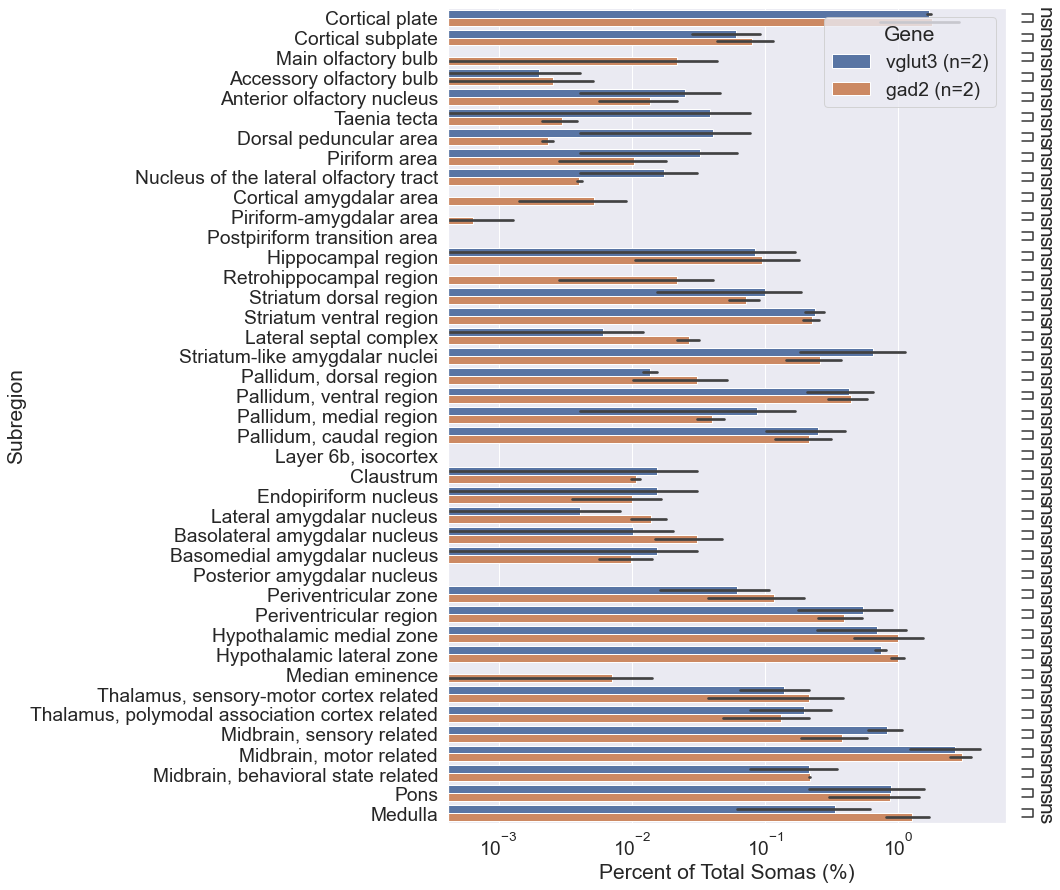

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(10, 15))
sns.set(font_scale=1.75)

fig_args = {
    "y": "Percent of Total Somas (%)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}

pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)

for subregion in unq_subregions:
    pairs.append(((subregion, "gad2 (n=2)"), (subregion, "vglut3 (n=2)")))


annotator = Annotator(axes, pairs, **fig_args)
fig_args = {
    "x": "Percent of Total Somas (%)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}

axes = sns.barplot(ax=axes, orient="h", **fig_args)
axes.set_xscale("log")

annotator.configure(test="Mann-Whitney", text_format="star", loc="outside")
annotator.new_plot(axes, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()


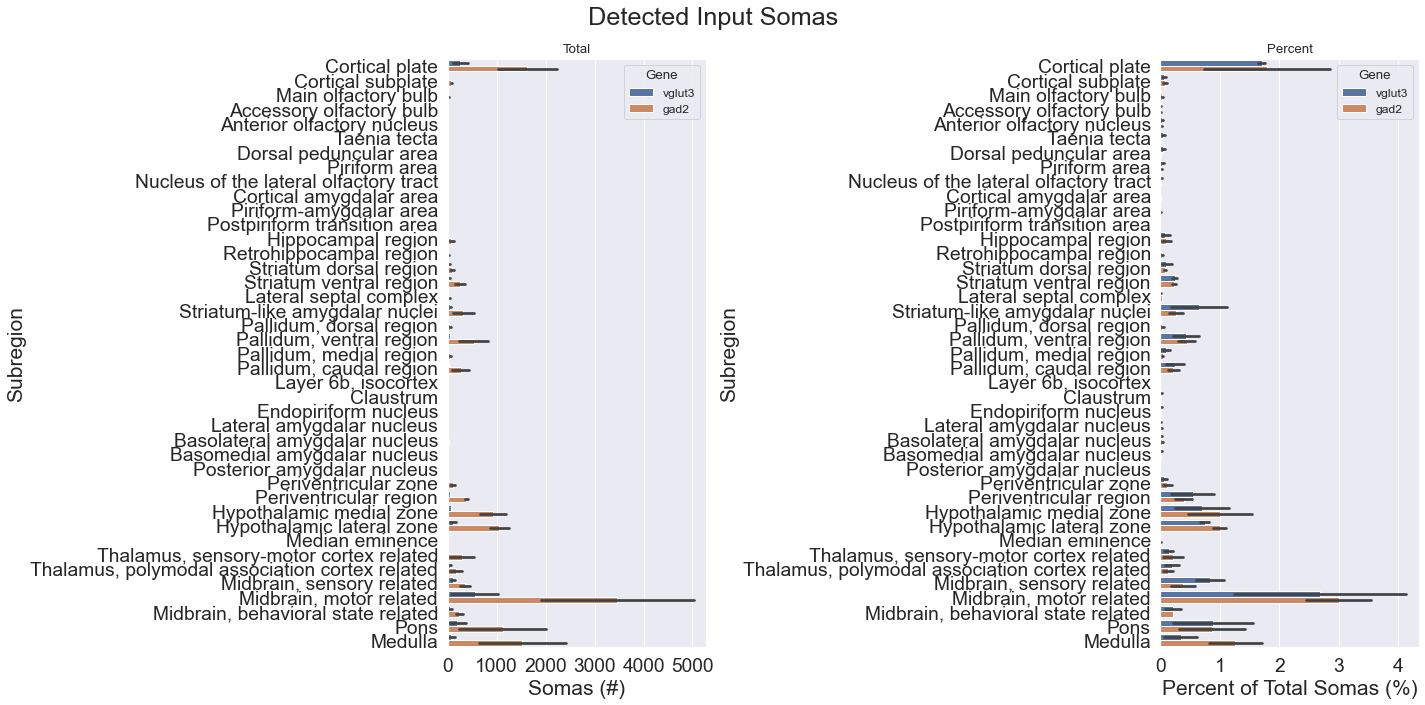

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Detected Input Somas")
sns.set(font_scale=1.1)

sns.barplot(ax=axes[0], x="Somas (#)", y="Subregion", hue="Gene", data=df)
axes[0].set_title("Total")

sns.barplot(
    ax=axes[1], x="Percent of Total Somas (%)", y="Subregion", hue="Gene", data=df
)
axes[1].set_title("Percent")

fig.tight_layout()

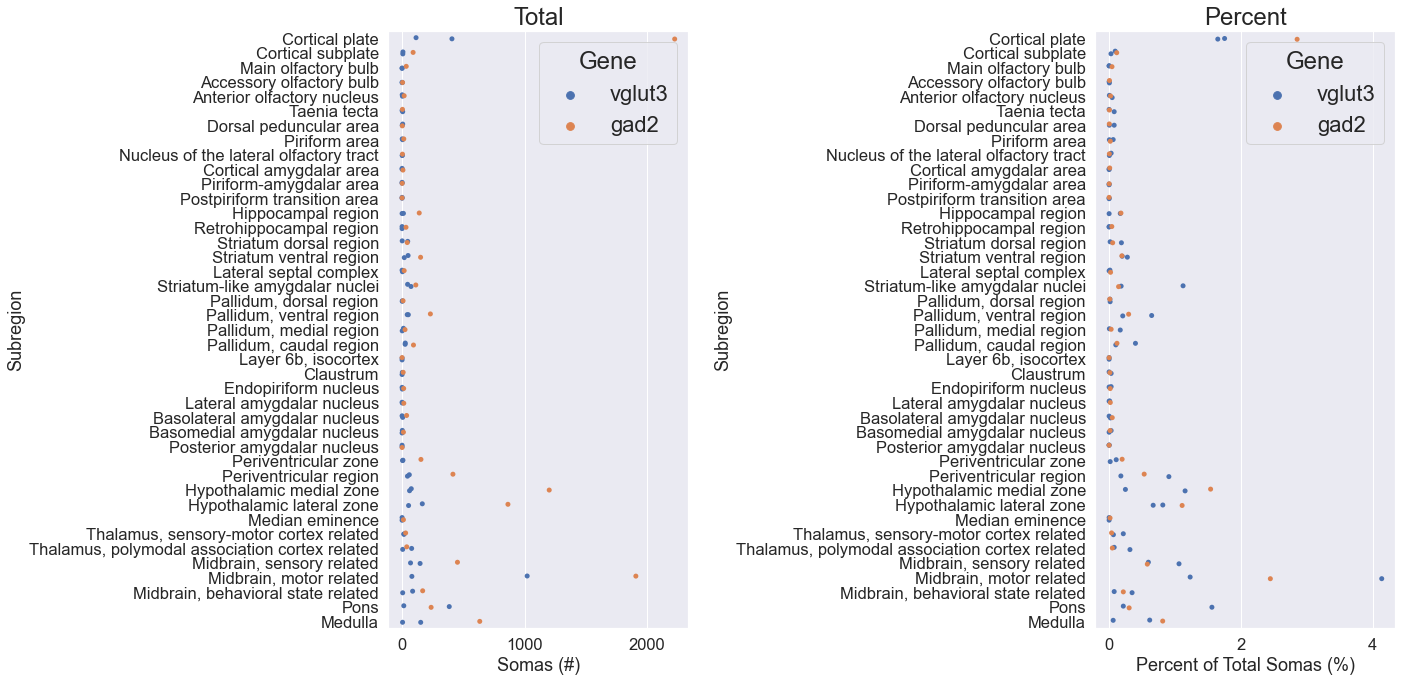

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.set(font_scale=2)

sns.stripplot(ax=axes[0], x="Somas (#)", y="Subregion", hue="Gene", data=df)
axes[0].set_title("Total")

sns.stripplot(
    ax=axes[1], x="Percent of Total Somas (%)", y="Subregion", hue="Gene", data=df
)
axes[1].set_title("Percent")

fig.tight_layout()

### Difference

In [42]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain]
    totals[brain] = total

somas_diff = []
somas_diff_sd = []
somas_pct_diff = []
somas_pct_diff_sd = []
gene = []
subregion_name = []
region_name = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        vglut = []
        gad = []
        vglut_pct = []
        gad_pct = []
        for brain in quantification_dicts.keys():
            if brain in ["8557", "8555"]:
                vglut.append(G.nodes[child][brain])
                vglut_pct.append(G.nodes[child][brain] / totals[brain] * 100)
            else:
                gad.append(G.nodes[child][brain])
                gad_pct.append(G.nodes[child][brain] / totals[brain] * 100)

        somas_diff.append(np.mean(gad) - np.mean(vglut))
        somas_diff_sd.append(np.sqrt(np.var(vglut) + np.var(gad)))
        somas_pct_diff.append(np.mean(gad_pct) - np.mean(vglut_pct))
        somas_pct_diff_sd.append(np.sqrt(np.var(vglut_pct) + np.var(gad_pct)))

        subregion_name.append(G.nodes[child]["name"])
        region_name.append(G.nodes[region]["name"])

d = {
    "Somas Difference (#)": somas_diff,
    "soma sd": somas_diff_sd,
    "Percent of Total Somas Difference (%)": somas_pct_diff,
    "pct sd": somas_pct_diff_sd,
    "Subregion": subregion_name,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Claustrum
Populating: Striatum
Populating: Pallidum
Populating: Cortical subplate
Populating: Hypothalamus
Populating: Thalamus
Populating: Midbrain
Populating: Hindbrain


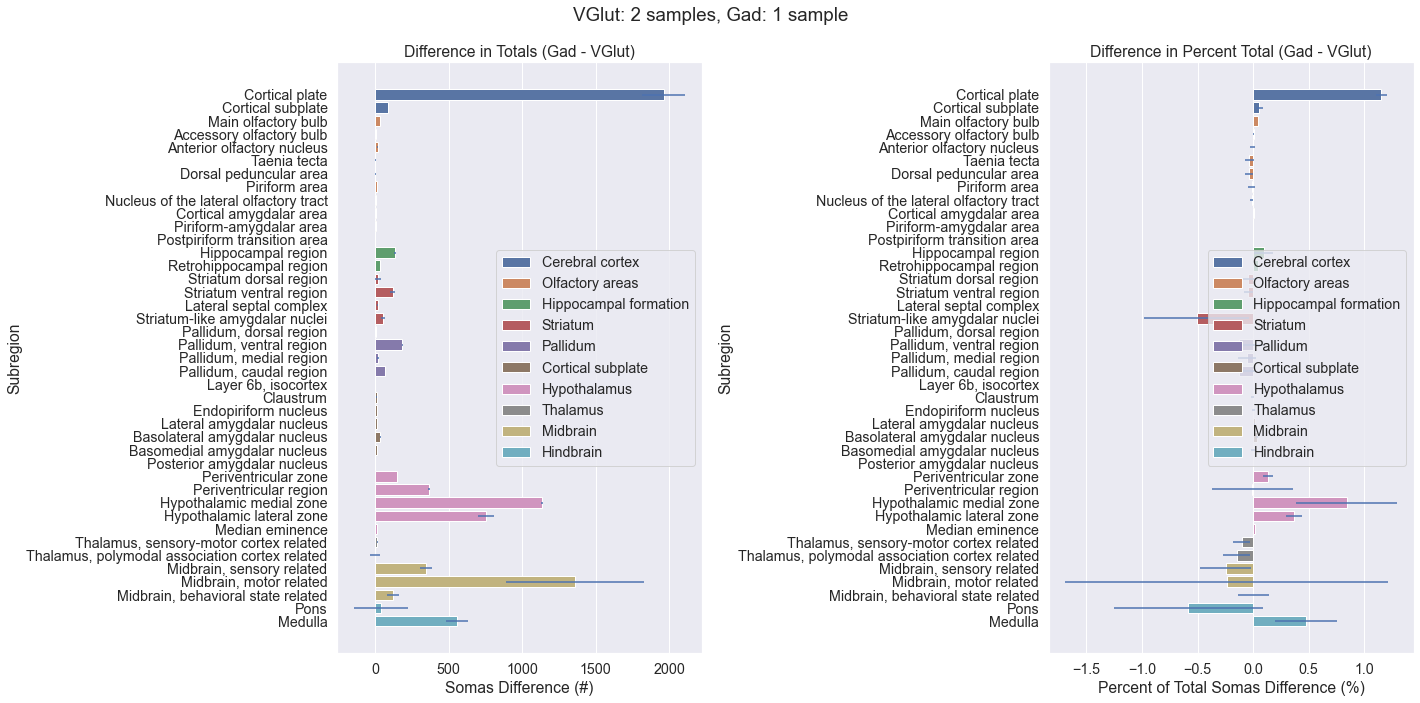

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("VGlut: 2 samples, Gad: 1 sample")

sns.set(font_scale=1.3)

p = sns.barplot(
    ax=axes[0],
    x="Somas Difference (#)",
    y="Subregion",
    data=df,
    hue="Region",
    dodge=False,
)
axes[0].errorbar(
    x=df["Somas Difference (#)"],
    y=np.arange(df.shape[0]),
    xerr=df["soma sd"],
    fmt="None",
)
axes[0].set_title("Difference in Totals (Gad - VGlut)")

p = sns.barplot(
    ax=axes[1],
    x="Percent of Total Somas Difference (%)",
    y="Subregion",
    data=df,
    hue="Region",
    dodge=False,
)
axes[1].errorbar(
    x=df["Percent of Total Somas Difference (%)"],
    y=np.arange(df.shape[0]),
    xerr=df["pct sd"],
    fmt="None",
)
axes[1].set_title("Difference in Percent Total (Gad - VGlut)")

axes[0].legend(loc="center right")
axes[1].legend(loc="center right")

fig.tight_layout()

### Relative difference (coefficient of variation)

In [55]:
import itertools

totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain]
    totals[brain] = total

somas_reldiff = []
somas_reldiff_sd = []
somas_pct_reldiff = []
somas_pct_reldiff_sd = []
gene = []
subregion_name = []
region_name = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        vglut = []
        gad = []
        vglut_pct = []
        gad_pct = []
        for brain in quantification_dicts.keys():
            if brain in ["8557", "8555"]:
                vglut.append(G.nodes[child][brain])
                vglut_pct.append(G.nodes[child][brain] / totals[brain] * 100)
            else:
                gad.append(G.nodes[child][brain])
                gad_pct.append(G.nodes[child][brain] / totals[brain] * 100)

        if np.mean(vglut) == 0:
            reldiff = 0
        else:
            reldiff = (np.mean(gad) - np.mean(vglut)) / np.mean(vglut)

        combos = list(itertools.product(gad, vglut))

        sum = 0
        for combo in combos:
            if combo[1] == 0:
                sum = 0
                break
            else:
                sum += (combo[0] / combo[1] - 1) ** 2

        sum = sum / len(combos)

        somas_reldiff.append(reldiff)
        somas_reldiff_sd.append(sum)
        # pct
        if np.mean(vglut_pct) == 0:
            reldiff = 0
        else:
            reldiff = (np.mean(gad_pct) - np.mean(vglut_pct)) / np.mean(vglut_pct)

        combos = list(itertools.product(gad_pct, vglut_pct))

        sum = 0
        for combo in combos:
            if combo[1] == 0:
                sum = 0
                break
            else:
                sum += (combo[0] / combo[1] - 1) ** 2

        sum = sum / len(combos)

        somas_pct_reldiff.append(reldiff)
        somas_pct_reldiff_sd.append(sum)

        subregion_name.append(G.nodes[child]["name"])
        region_name.append(G.nodes[region]["name"])

d = {
    "Somas Relative Difference": somas_reldiff,
    "soma sd": somas_reldiff_sd,
    "Percent of Total Somas Relative Difference": somas_pct_reldiff,
    "pct sd": somas_pct_reldiff_sd,
    "Subregion": subregion_name,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Claustrum
Populating: Striatum
Populating: Pallidum
Populating: Cortical subplate
Populating: Hypothalamus
Populating: Thalamus
Populating: Midbrain
Populating: Hindbrain


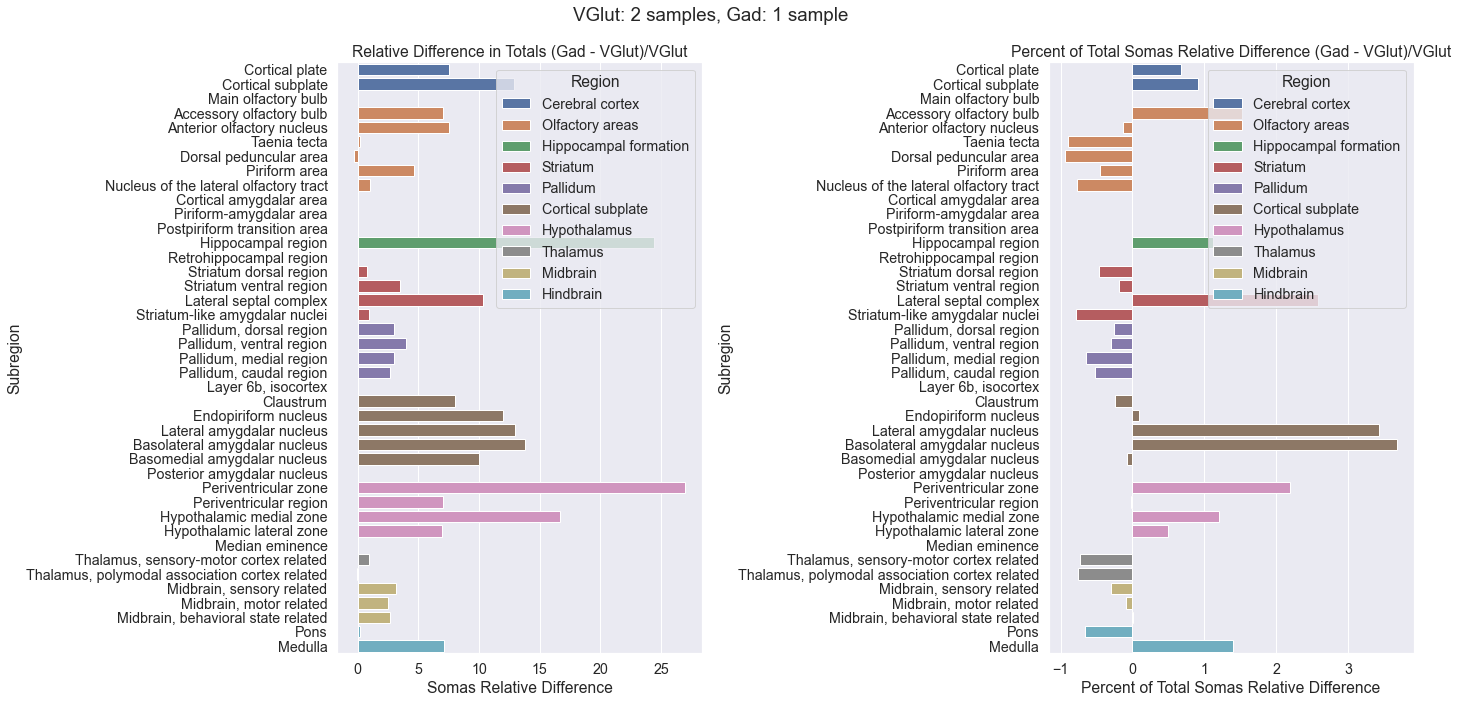

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("VGlut: 2 samples, Gad: 1 sample")

p = sns.barplot(
    ax=axes[0],
    x="Somas Relative Difference",
    y="Subregion",
    data=df,
    hue="Region",
    dodge=False,
)
# axes.errorbar(x = df["Somas Relative Difference"], y = np.arange(df.shape[0]),  xerr=df["soma sd"], fmt='None')
axes[0].set_title("Relative Difference in Totals (Gad - VGlut)/VGlut")

p = sns.barplot(
    ax=axes[1],
    x="Percent of Total Somas Relative Difference",
    y="Subregion",
    data=df,
    hue="Region",
    dodge=False,
)
# axes[1].errorbar(x = df["Percent of Total Somas Difference (%)"], y = np.arange(df.shape[0]),  xerr=df["pct sd"], fmt='None')
axes[1].set_title("Percent of Total Somas Relative Difference (Gad - VGlut)/VGlut")


fig.tight_layout()

## Make bar charts

In [ ]:
def get_bar_info(G, color_num=0):
    total = 0
    for node in G.nodes:
        total += G.nodes[node]["somas"]

    cmap = mpl.cm.get_cmap("tab20")

    y_pos = [0]
    width = []
    labels = []
    colors = []
    for r, region in enumerate(regions):

        print(f"Populating: " + G.nodes[region]["name"])
        names = []
        somas = []
        children = list(G.successors(region))
        n_entries = np.amax([len(children), 1])
        y_pos += list(np.arange(y_pos[-1] + 2, y_pos[-1] + n_entries + 2))
        if len(children) > 0:
            for child in children:
                labels.append(G.nodes[child]["name"])
                width.append(G.nodes[child]["somas"] / total * 100)
                colors.append(cmap(2 * r + color_num))
        else:
            labels.append(G.nodes[region]["name"])
            width.append(G.nodes[region]["somas"] / total * 100)
            colors.append(cmap(2 * r + color_num))

    y_pos = [-1 * y for y in y_pos]
    y_pos = np.array(y_pos[1:])
    return y_pos, width, labels, colors

In [ ]:
height = 0.4

fig, ax = plt.subplots(figsize=(10, 10))

y_pos, width, labels, colors = get_bar_info(G, 0)
ax.barh(
    y=y_pos, width=width, height=height, tick_label=labels, color=colors, label="8557"
)
y_pos, width, labels, colors = get_bar_info(G3, 1)
ax.barh(
    y=y_pos + height,
    width=width,
    height=height,
    tick_label=labels,
    color=colors,
    label="8607",
)

ax.legend()
ax.set_xlabel("Percent of total inputs (%)")

In [ ]:
labels

## Create data json

In [ ]:
def get_entry(node):
    entry = {"name": G.nodes[node]["name"]}
    successor_nodes = list(G.successors(node))
    somas = G.nodes[node]["somas"]

    if len(successor_nodes) > 0:
        children_somas = 0
        children = []
        for child in successor_nodes:
            children_somas += G.nodes[child]["somas"]
            child_entry = get_entry(child)
            if child_entry is not None:
                children.append(child_entry)
        if children_somas < somas:
            children.append({"name": "other", "value": somas - children_somas})
        entry["children"] = children
        return entry
    elif somas > 0:
        entry["value"] = somas
        return entry
    else:
        return

In [ ]:
import json

for node in G.nodes:
    if G.nodes[node]["level"] == 0:
        print(node)

In [ ]:
json_string = json.dumps(get_entry(997))
print(json_string)
with open(
    "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/d3js/somas.json",
    "w",
    encoding="utf-8",
) as outfile:
    json.dump(get_entry(997), outfile, ensure_ascii=False, indent=4)

## create nested chart

In [ ]:
def sort_pairs(tosort, other):
    zipped_lists = zip(tosort, other)
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    list1, list2 = [list(tuple) for tuple in tuples]
    return list1, list2

In [ ]:
acros_4 = []
acros_5 = []
acros_6 = []
somas_4 = []
somas_5 = []
somas_6 = []
none = []

for node in G.nodes:
    if G.nodes[node]["st_level"] == 3:
        if G.nodes[node]["somas"] > 0:
            acros_4.append(G.nodes[node]["name"])
            somas_4.append(G.nodes[node]["somas"])

            children = G.successors(node)
            child_somas_counter = 0
            child_somas = []
            child_names = []

            for child in children:
                if G.nodes[child]["somas"] > 5:
                    child_names.append(G.nodes[child]["name"])
                    child_somas.append(G.nodes[child]["somas"])
                    child_somas_counter += G.nodes[child]["somas"]

                    grandchildren = G.successors(child)
                    grandchild_somas_counter = 0
                    grandchild_somas = []
                    grandchild_names = []
                    for grandchild in grandchildren:
                        if G.nodes[grandchild]["somas"] > 5:
                            grandchild_names.append(G.nodes[grandchild]["name"])
                            grandchild_somas.append(G.nodes[grandchild]["somas"])
                            grandchild_somas_counter += G.nodes[grandchild]["somas"]

                    if grandchild_somas_counter > G.nodes[child]["somas"]:
                        raise ValueError()
                    elif grandchild_somas_counter < G.nodes[child]["somas"]:
                        diff = G.nodes[child]["somas"] - grandchild_somas_counter
                        grandchild_names.append("other")
                        grandchild_somas.append(diff)

                    grandchild_somas, grandchild_names = sort_pairs(
                        grandchild_somas, grandchild_names
                    )
                    somas_6.extend(grandchild_somas)
                    acros_6.extend(grandchild_names)

            if child_somas_counter > G.nodes[node]["somas"]:
                raise ValueError()
            elif child_somas_counter < G.nodes[node]["somas"]:
                diff = G.nodes[node]["somas"] - child_somas_counter
                child_names.append("other")
                child_somas.append(diff)

            # child_somas, child_names = sort_pairs(child_somas, child_names)
            somas_5.extend(child_somas)
            acros_5.extend(child_names)

        else:
            none.append(G.nodes[node]["name"])


fig, ax = plt.subplots()

width = 1
ax.pie(
    somas_4,
    radius=1,
    labels=acros_4,
    labeldistance=0.3,
    wedgeprops=dict(width=width, edgecolor="w"),
)

ax.pie(
    somas_5,
    radius=2,
    labels=acros_5,
    labeldistance=0.6,
    wedgeprops=dict(width=width, edgecolor="w"),
)

ax.pie(somas_6, radius=3, labels=acros_6, wedgeprops=dict(width=width, edgecolor="w"))

plt.title(
    f"Brain R1 - {np.sum(somas_4)} Total Somas \n Inner Ring = ARA Level 3",
    pad=220,
    fontdict={"fontsize": 20},
)

In [ ]:
acros_4 = []
acros_5 = []
somas_4 = []
somas_5 = []
none = []

for node in G.nodes:
    if G.nodes[node]["st_level"] == 5:
        if G.nodes[node]["somas"] > 0:
            acros_4.append(G.nodes[node]["name"])
            somas_4.append(G.nodes[node]["somas"])

            children = G.successors(node)
            child_somas_counter = 0
            child_somas = []
            child_names = []

            for child in children:
                if G.nodes[child]["somas"] > 5:
                    child_names.append(G.nodes[child]["name"])
                    child_somas.append(G.nodes[child]["somas"])
                    child_somas_counter += G.nodes[child]["somas"]

            if child_somas_counter > G.nodes[node]["somas"]:
                raise ValueError()
            elif child_somas_counter < G.nodes[node]["somas"]:
                diff = G.nodes[node]["somas"] - child_somas_counter
                child_names.append("other")
                child_somas.append(diff)

            child_somas, child_names = sort_pairs(child_somas, child_names)
            somas_5.extend(child_somas)
            acros_5.extend(child_names)

        else:
            none.append(G.nodes[node]["name"])


fig, ax = plt.subplots()

width = 2
ax.pie(
    somas_4,
    radius=width,
    labels=acros_4,
    labeldistance=0.5,
    wedgeprops=dict(width=width, edgecolor="w"),
)

ax.pie(
    somas_5,
    radius=2 * width,
    labels=acros_5,
    wedgeprops=dict(width=width, edgecolor="w"),
)


plt.title(
    f"Brain R1 - {np.sum(somas_4)} Total Somas \n Inner Ring = ARA Level 5",
    pad=320,
    fontdict={"fontsize": 20},
)

In [ ]:
acros = []
somas = []
none = []
lvl = 6

for node in G.nodes:
    if G.nodes[node]["st_level"] == lvl:
        if G.nodes[node]["somas"] > 0:
            acros.append(G.nodes[node]["name"])
            somas.append(G.nodes[node]["somas"])
        else:
            none.append(G.nodes[node]["name"])

volumes = np.multiply(somas, 6.7 / (1000**3))
plt.bar(acros, somas)
plt.ylabel("Soma Count", fontsize=20)
plt.xlabel("ARA region")
plt.title(f"Level {lvl}", fontsize=20)
plt.xticks(rotation=75, fontsize=20)
plt.yticks(fontsize=20)

fig = plt.gcf()
fig.set_size_inches(26, 5)
plt.show()

print(f"Areas with none detected: {none}")

In [ ]:
nodes = []
for n in G.nodes:
    if G.nodes[n]["st_level"] <= 5:
        nodes.append(n)
len(nodes)
G2 = G.subgraph(nodes)

In [ ]:
pos_dict = {}
label_dict = {}
for level in np.arange(12):
    counter = 0
    for n in G2.nodes:
        if G2.nodes[n]["st_level"] == level:
            pos_dict[n] = (100 * counter, 11 - level)
            counter += 1
            label_dict[n] = G2.nodes[n]["acronym"]

In [ ]:
nx.draw_networkx(G2, pos_dict, labels=label_dict, node_size=1000)

In [ ]:
net = Network(notebook=True)
net.from_nx(G2)
net.show("example.html")  # only works on jupyter nb

## View transformed coords

In [62]:
import json
from cloudvolume import CloudVolume
from skimage import io
import numpy as np
from tqdm import tqdm
import napari
from skimage import measure
import scipy.ndimage as ndi
from napari_animation import AnimationWidget

In [64]:
vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017",
    mip=0,
    parallel=1,
    progress=False,
)
new_res = vol.resolution
og_res = [3.72, 3.72, 4]
res_factor = [i / j * 1000 for i, j in zip(og_res, new_res)]
print(f"ARA Resolution: {new_res}nm")

with open(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/misc_results/transformed_points_r1.json"
) as f:
    data = json.load(f)

points = []
for entry in data:
    point = [int(i * j) for i, j in zip(res_factor, entry["point"])]
    points.append(point)
points_r1 = np.array(points)

with open(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/misc_results/transformed_points_r2.json"
) as f:
    data = json.load(f)

points = []
for entry in data:
    point = [int(i * j) for i, j in zip(res_factor, entry["point"])]
    points.append(point)
points_r2 = np.array(points)

with open(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/soma_detection/misc_results/transformed_points_r3.json"
) as f:
    data = json.load(f)

points = []
for entry in data:
    point = [int(i * j) for i, j in zip(res_factor, entry["point"])]
    points.append(point)
points_r3 = np.array(points)


# atlas = np.zeros(vol.shape, dtype=vol.dtype)

ARA Resolution: [10000 10000 10000]nm


In [65]:
atlas = io.imread(
    "/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif"
)

In [66]:
v = napari.Viewer()
# v.add_labels(atlas)
v.add_points(points_r1, face_color="red", size=5)
v.add_points(points_r2, face_color="orange", size=5)
v.add_points(points_r3, face_color="blue", size=5)
animation_widget = AnimationWidget(v)
v.window.add_dock_widget(animation_widget, area="right")

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/napari_animation/_qt/keyframeslist_widget.py:156: FutureWarning: Themes were changed to use evented model with Pydantic's color type rather than the `rgb(x, y, z)`. The `as_dict=True` option will be changed to `as_dict=False` in 0.4.15
  self.setStyleSheet(template(qss_template, **get_theme(theme_name)))


In [67]:
for z in [380, 680, 980]:
    slice = atlas[z, :, :]
    labels = measure.label(slice)
    borders = 0 * labels
    for label in np.unique(labels):
        if label != 0:
            mask = np.array(labels == label, dtype="int")
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    points_r12d = []
    for point in points_r1:
        if point[0] > z - 10 and point[0] < z + 10:
            points_r12d.append([point[1], point[2]])
    points_r22d = []
    for point in points_r2:
        if point[0] > z - 10 and point[0] < z + 10:
            points_r22d.append([point[1], point[2]])
    points_r32d = []
    for point in points_r3:
        if point[0] > z - 10 and point[0] < z + 10:
            points_r32d.append([point[1], point[2]])

    v = napari.Viewer()
    v.add_image(borders)
    v.add_points(points_r12d, face_color="red", size=10)
    v.add_points(points_r22d, face_color="orange", size=10)
    v.add_points(points_r32d, face_color="blue", size=10)

In [105]:
v = napari.Viewer()
v.add_image(borders)
v.add_points(points_r12d, face_color="red", size=10)
v.add_points(points_r22d, face_color="orange", size=10)
v.add_points(points_r32d, face_color="blue", size=10)
animation_widget = AnimationWidget(v)
v.window.add_dock_widget(animation_widget, area="right")

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/napari_animation/_qt/keyframeslist_widget.py:156: FutureWarning: Themes were changed to use evented model with Pydantic's color type rather than the `rgb(x, y, z)`. The `as_dict=True` option will be changed to `as_dict=False` in 0.4.15
  self.setStyleSheet(template(qss_template, **get_theme(theme_name)))


### download atlas as chunks

In [ ]:
for i in tqdm(range(0, atlas.shape[2], 10)):
    atlas[:, :, i : i + 10, :] = vol[:, :, i : i + 10, :]

In [ ]:
# io.imsave("/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif", atlas)

## Make plots

In [ ]:
atlas.shape

In [ ]:
np.amax(points_r1, axis=0)

In [ ]:
for z in [180, 430, 680, 1030, 1280]:
    slice = atlas[z, :, :]
    labels = measure.label(slice)
    borders = 0 * labels
    for label in np.unique(labels):
        if label != 0:
            mask = np.array(labels == label, dtype="int")
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    plt.imshow(borders, cmap="gray")
    indices = np.logical_and((points_r1[:, 0] < z + 3), (points_r1[:, 0] > z - 3))
    plt.scatter(points_r1[indices, 2], points_r1[indices, 1], c="b", s=5)
    indices = np.logical_and((points_r3[:, 0] < z + 3), (points_r3[:, 0] > z - 3))
    plt.scatter(points_r3[indices, 2], points_r3[indices, 1], c="r", s=5)

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig("/Users/thomasathey/Desktop/" + str(z) + ".png", dpi=100)

In [ ]:
a = np.zeros((10, 10, 10))
b = [[1.1, 1.1, 1.1], [2.1, 2.1, 2.1]]
v = napari.Viewer()
v.add_image(a)
v.add_points(b)